In [1]:
from numpy import *
from matplotlib.pylab import *
import random
import sys
import io
import os
import glob
import h5py

import IPython

#from pydub import AudioSegment
#from td_utils import *

/users/bssn/serna/environments/deepl/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
!jupyter kernelspec list

Available kernels:
  deepl      /export/home1/users/bssn/serna/.local/share/jupyter/kernels/deepl
  python3    /export/home1/users/bssn/serna/.local/share/jupyter/kernels/python3


In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1320059741676134574
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7907914548
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6602235013305328571
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [72]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, Concatenate
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.regularizers import L1L2
from keras import backend as K
from keras.layers import MaxPooling1D, AveragePooling1D,Conv1D
from keras.layers import Lambda
from keras.backend import transpose
from keras import regularizers

In [5]:
Tx,size = Ft.shape
#nfreq = 101

NameError: name 'Ft' is not defined

In [6]:
def get_random_time_segment(segment_frames,total_frames=12000):
    '''
    Gets a random time segment of duration segment_frames in a file
    with number of frames: total_frames
    '''
    
    segment_start = randint(0, high = total_frames-
                                   segment_frames)
    segment_end = segment_start + segment_frames
    
    return (segment_start, segment_end)

## Loading data set.

This is a big dataset, so we are going to divide it in 4000 samples for  training set and 100 dev_set and 100 test_set.

In [7]:
pars = load("Training/roival.npy")
print(len(pars),pars)

1015 [0 0 0 ... 0 0 0]


It is not a NR


<Figure size 432x288 with 0 Axes>

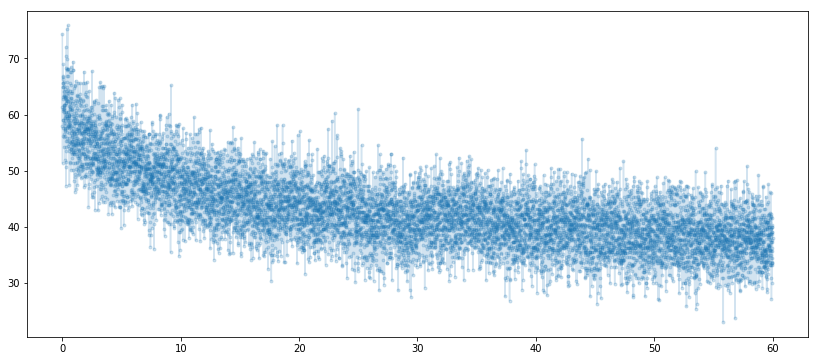

<Figure size 432x288 with 0 Axes>

In [36]:
i = randint(0,len(pars))
Ft = load("Training/roi"+str(i).zfill(4)+".npy")
t = arange(Ft.shape[0])*5e-3
if pars[i] == 0:
    print("It is not a NR")
else:
    print("It is a NR")
    
figure(figsize= (14,6))
plot(t,mean(Ft-Ft.min(axis=0),axis=1),'.-',alpha=0.2)
figure()

In [56]:
def getdataextract(xt):
    duration, roisize = xt.shape
    start,end = get_random_time_segment(nframes,total_frames=duration)
    xtt = xt[start:end,:].transpose()
    s1 = xtt.mean()
    s0 = xtt.std()/s1
    s2 = xtt.std()
    s3 = mean((xtt-s1)**3)/s2**3
    s4 = mean((xtt-s1)**4)/s2**4
    xtt = xtt-xtt.min(axis=0)
    xtt = xtt.mean(axis=0)
    xtt = xtt/xtt.mean()
    s1n = xtt.mean()
    s2n = xtt.std()
    s3n = mean((xtt-s1n)**3)/s2n**3
    s4n = mean((xtt-s1n)**4)/s2n**4
    s0t = array([s2,s3,s4,(s3**2+1)/s4,s2n,s3n,s4n,(s3**2+1)/s4])
    xtt = concatenate((s0t,xtt))
    return(xtt)

In [57]:
# 1 segundo. This will be used as another (meta)parameter, 
# which we want to decrease
nframes = 1000 
pars = load("Training/roival.npy")

lpar = len(pars)

X = []
Y = []
for i in permutation(lpar-200):
    xt = load("Training/roi"+str(i).zfill(4)+".npy")
    par = pars[i]
    nj = 3
    if par == 1: nj = 8
    for j in range(nj):
        X.append(getdataextract(xt))
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    

Xdev = []
Ydev = []
for i in range(lpar-200,lpar):
    xt = load("Training/roi"+str(i).zfill(4)+".npy")
    par = pars[i]
    for j in range(5):
        Xdev.append(getdataextract(xt))
        #Ydev.append(concatenate((yt[start:end],par[-1:])))
        Ydev.append(par)
Xdev = array(Xdev)
Ydev = array(Ydev)

print(Xdev.shape, Ydev.shape)


'''
Xdev = array(X).transpose()
Ydev = array(Y).transpose()
for i in range(4000,4100):
    xt = load("syndat/d"+str(i).zfill(4)+".npy")
    yt = load("syndat/r"+str(i).zfill(4)+".npy")
    for j in range(20):
        start,end = get_random_time_segment(nframes)
        Xdev.append(xt[start:end])
        Ydev.append(yt[start:end])
'''        
        

(3465, 1008) (3465,)
(1000, 1008) (1000,)


'\nXdev = array(X).transpose()\nYdev = array(Y).transpose()\nfor i in range(4000,4100):\n    xt = load("syndat/d"+str(i).zfill(4)+".npy")\n    yt = load("syndat/r"+str(i).zfill(4)+".npy")\n    for j in range(20):\n        start,end = get_random_time_segment(nframes)\n        Xdev.append(xt[start:end])\n        Ydev.append(yt[start:end])\n'

It is not a NR


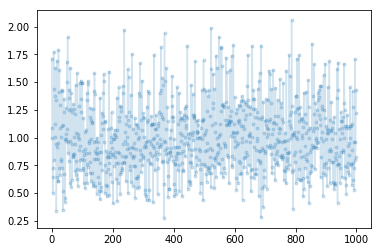

In [60]:
colors = array(['C0','C1'])
t = arange(nframes)
# We plot some random pieces we chose to fit the network!

i = randint(0,X.shape[0])

if Y[i] == 0:
    print("It is not a NR")
else:
    print("It is a NR")

plot(t,X[i,8:],'.-',alpha=0.2)


In [61]:
X.shape

(3465, 1008)

In [62]:
sum(Y==1)

1632

## Definition of the network

Here, we define the neural network. We may start with just nframes logistic regressions?!

In [63]:
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1,1))

Xdev = reshape(Xdev,(Xdev.shape[0],Xdev.shape[1],1))
Ydev = reshape(Ydev,(Ydev.shape[0],1,1))

print(X.shape,Y.shape)

(3465, 1008, 1) (3465, 1, 1)


In [185]:
def model(input_shape):
    '''
    Function used to create the model's graph in Keras
    
    Argument:
    -- input_shape. Shape of the model's input data (Keras conventions?!)
    
    Returns:
    -- model. Keras model instance
    '''
    tf_session = K.get_session()
    
    X_input = Input(shape = input_shape)
    
    # Layers

    X = X_input
    
    n0par = 8
    Xa = Lambda(lambda x: x[:,n0par:,:], output_shape=(input_shape[0]-n0par,1))(X)
    X  = Lambda(lambda x: x[:,:n0par,:], output_shape=(n0par,1))(X)
    X = Reshape((1,n0par))(X)
 
    Xashape = array(input_shape)
    Xashape[-1] -= 1 
    n1, n2, s = (20,10,4)

    Xa = Dropout(0.2)(Xa)
    Xb = Conv1D(20,40,strides=5,padding="valid")(Xa)
    Xc = AveragePooling1D(40,strides=5,padding="valid")(Xa)
    Xa = MaxPooling1D(40,strides=5,padding="valid")(Xa)
    
    Xa = Concatenate()([Xa,Xb,Xc])
    Xa = BatchNormalization()(Xa)   

    Xa = Dropout(0.2)(Xa)
    Xa = Conv1D(60,30,strides=7,padding="same")(Xa)
    Xa = Activation("relu")(Xa)
    Xa = BatchNormalization()(Xa)   
    
    
    Xa = Reshape((1,28*60))(Xa)
    X = Concatenate(axis=2)([X,Xa])
    X = BatchNormalization()(X)
    
    
    X = Dropout(0.2)(X)
    X = Dense(40,activation="relu")(X)
    X = BatchNormalization()(X)
    
    X = Dropout(0.2)(X)
    X = Dense(20,activation="relu")(X)
    X = BatchNormalization()(X)
     
    
    X = Dropout(0.2)(X)
    X = Dense(4,activation="sigmoid")(X)
    X = BatchNormalization()(X)
    
    X = Dense(1,activation="sigmoid")(X)

    #X = Xa
    # Defining the model
    
    model = Model(inputs = X_input, outputs = X)
    
    return model

In [186]:
model = model(input_shape = (8+nframes,1))

In [187]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_28 (InputLayer)           (None, 1008, 1)      0                                            
__________________________________________________________________________________________________
lambda_55 (Lambda)              (None, 1000, 1)      0           input_28[0][0]                   
__________________________________________________________________________________________________
dropout_102 (Dropout)           (None, 1000, 1)      0           lambda_55[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_36 (MaxPooling1D) (None, 193, 1)       0           dropout_102[0][0]                
__________________________________________________________________________________________________
conv1d_54 

### Fit the model!

In [188]:
from keras.optimizers import SGD

In [189]:
opt = Adam(lr=0.001, beta_1=0.95, beta_2=0.999, decay=0.001)
#opt = SGD(lr=100, decay=1e-6, momentum=1.9)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])


In [190]:
Wsave = model.get_weights()
#model.set_weights(Wsave)

In [191]:
Y.shape

(3003, 1, 1)

In [192]:
history3 = model.fit(X, Y, batch_size = 500, epochs =1000)

Epoch 1/1000
3003/3003 [==============================] - 4s 1ms/step - loss: 1.0315 - acc: 0.5088
Epoch 2/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.7964 - acc: 0.6117
Epoch 3/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.6778 - acc: 0.6560
Epoch 4/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.6263 - acc: 0.6873
Epoch 5/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.6050 - acc: 0.6983
Epoch 6/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.5564 - acc: 0.7216
Epoch 7/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.5336 - acc: 0.7479
Epoch 8/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.5447 - acc: 0.7379
Epoch 9/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.5247 - acc: 0.7486
Epoch 10/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.5180 - acc: 0.7479


3003/3003 [==============================] - 0s 58us/step - loss: 0.4244 - acc: 0.8089
Epoch 83/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.4270 - acc: 0.8089
Epoch 84/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.4235 - acc: 0.8019
Epoch 85/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.4288 - acc: 0.8052
Epoch 86/1000
3003/3003 [==============================] - 0s 60us/step - loss: 0.4275 - acc: 0.8085
Epoch 87/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.4096 - acc: 0.8168
Epoch 88/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.4242 - acc: 0.8079
Epoch 89/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.4192 - acc: 0.8129
Epoch 90/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.4269 - acc: 0.8122
Epoch 91/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.4139 - acc: 0.8232
Epoc

3003/3003 [==============================] - 0s 58us/step - loss: 0.4016 - acc: 0.8305
Epoch 163/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3912 - acc: 0.8385
Epoch 164/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3937 - acc: 0.8345
Epoch 165/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3959 - acc: 0.8305
Epoch 166/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.4005 - acc: 0.8245
Epoch 167/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3953 - acc: 0.8318
Epoch 168/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3998 - acc: 0.8305
Epoch 169/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3926 - acc: 0.8332
Epoch 170/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3894 - acc: 0.8358
Epoch 171/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3927 - acc: 0.

3003/3003 [==============================] - 0s 60us/step - loss: 0.3812 - acc: 0.8398
Epoch 243/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3843 - acc: 0.8382
Epoch 244/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3755 - acc: 0.8432
Epoch 245/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3779 - acc: 0.8478
Epoch 246/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3761 - acc: 0.8448
Epoch 247/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3789 - acc: 0.8412
Epoch 248/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3732 - acc: 0.8395
Epoch 249/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3752 - acc: 0.8465
Epoch 250/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3785 - acc: 0.8452
Epoch 251/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3919 - acc: 0.

3003/3003 [==============================] - 0s 60us/step - loss: 0.3855 - acc: 0.8372
Epoch 323/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3821 - acc: 0.8375
Epoch 324/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3760 - acc: 0.8425
Epoch 325/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3845 - acc: 0.8348
Epoch 326/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3724 - acc: 0.8435
Epoch 327/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3761 - acc: 0.8388
Epoch 328/1000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3725 - acc: 0.8418
Epoch 329/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3712 - acc: 0.8388
Epoch 330/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3703 - acc: 0.8521
Epoch 331/1000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3770 - acc: 0.

3003/3003 [==============================] - 0s 58us/step - loss: 0.3715 - acc: 0.8458
Epoch 403/1000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3711 - acc: 0.8438
Epoch 404/1000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3768 - acc: 0.8392
Epoch 405/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3746 - acc: 0.8432
Epoch 406/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3746 - acc: 0.8428
Epoch 407/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3646 - acc: 0.8448
Epoch 408/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3692 - acc: 0.8438
Epoch 409/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3745 - acc: 0.8415
Epoch 410/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3783 - acc: 0.8345
Epoch 411/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3666 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3570 - acc: 0.8551
Epoch 483/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3672 - acc: 0.8442
Epoch 484/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3581 - acc: 0.8545
Epoch 485/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3627 - acc: 0.8448
Epoch 486/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3737 - acc: 0.8428
Epoch 487/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3617 - acc: 0.8498
Epoch 488/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3706 - acc: 0.8492
Epoch 489/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3699 - acc: 0.8508
Epoch 490/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3686 - acc: 0.8452
Epoch 491/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3507 - acc: 0.

3003/3003 [==============================] - 0s 58us/step - loss: 0.3614 - acc: 0.8478
Epoch 563/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3714 - acc: 0.8415
Epoch 564/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3684 - acc: 0.8448
Epoch 565/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3574 - acc: 0.8535
Epoch 566/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3644 - acc: 0.8475
Epoch 567/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3669 - acc: 0.8505
Epoch 568/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3582 - acc: 0.8531
Epoch 569/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3575 - acc: 0.8495
Epoch 570/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3524 - acc: 0.8578
Epoch 571/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3625 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3639 - acc: 0.8455
Epoch 643/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3620 - acc: 0.8521
Epoch 644/1000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3392 - acc: 0.8601
Epoch 645/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3658 - acc: 0.8528
Epoch 646/1000
3003/3003 [==============================] - 0s 62us/step - loss: 0.3548 - acc: 0.8561
Epoch 647/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3549 - acc: 0.8581
Epoch 648/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3635 - acc: 0.8581
Epoch 649/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3615 - acc: 0.8462
Epoch 650/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3593 - acc: 0.8511
Epoch 651/1000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3532 - acc: 0.

3003/3003 [==============================] - 0s 56us/step - loss: 0.3467 - acc: 0.8578
Epoch 723/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3654 - acc: 0.8455
Epoch 724/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3526 - acc: 0.8548
Epoch 725/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3594 - acc: 0.8485
Epoch 726/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3600 - acc: 0.8535
Epoch 727/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3574 - acc: 0.8531
Epoch 728/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3508 - acc: 0.8535
Epoch 729/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3589 - acc: 0.8511
Epoch 730/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3639 - acc: 0.8505
Epoch 731/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3578 - acc: 0.

3003/3003 [==============================] - 0s 59us/step - loss: 0.3587 - acc: 0.8525
Epoch 803/1000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3516 - acc: 0.8581
Epoch 804/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3686 - acc: 0.8528
Epoch 805/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3538 - acc: 0.8605
Epoch 806/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3560 - acc: 0.8511
Epoch 807/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3534 - acc: 0.8541
Epoch 808/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3522 - acc: 0.8568
Epoch 809/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3662 - acc: 0.8472
Epoch 810/1000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3600 - acc: 0.8575
Epoch 811/1000
3003/3003 [==============================] - 0s 62us/step - loss: 0.3523 - acc: 0.

3003/3003 [==============================] - 0s 60us/step - loss: 0.3636 - acc: 0.8511
Epoch 883/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3591 - acc: 0.8551
Epoch 884/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3562 - acc: 0.8565
Epoch 885/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3506 - acc: 0.8578
Epoch 886/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3584 - acc: 0.8598
Epoch 887/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3649 - acc: 0.8511
Epoch 888/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3484 - acc: 0.8578
Epoch 889/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3452 - acc: 0.8595
Epoch 890/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3530 - acc: 0.8585
Epoch 891/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3563 - acc: 0.

3003/3003 [==============================] - 0s 58us/step - loss: 0.3581 - acc: 0.8548
Epoch 963/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3531 - acc: 0.8605
Epoch 964/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3488 - acc: 0.8558
Epoch 965/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3516 - acc: 0.8568
Epoch 966/1000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3460 - acc: 0.8598
Epoch 967/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3525 - acc: 0.8581
Epoch 968/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3505 - acc: 0.8568
Epoch 969/1000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3497 - acc: 0.8601
Epoch 970/1000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3540 - acc: 0.8595
Epoch 971/1000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3548 - acc: 0.

In [193]:
Wsave_trained1 = model.get_weights()
#Wsave_trained2 = model.get_weights()
#Wsave_trained3 = model.get_weights()

dict_keys(['loss', 'acc'])


Text(0.5,0,'epoch')

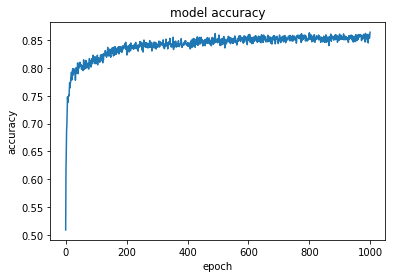

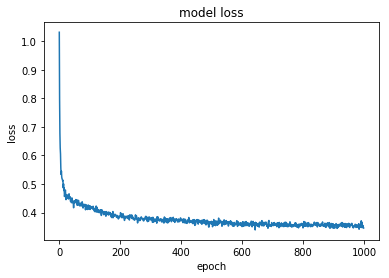

In [194]:
figure()
print(history3.history.keys())
#plot(history.history['acc'])
plot(history3.history['acc'])
#plot(history4.history['acc'])

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
figure()
#plot(history.history['loss'])
plot(history3.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')


In [213]:
loss, acc = model.evaluate(Xdev, Ydev)
print("Dev set accuracy = ", acc)

1000/1000 [==============================] - 0s 165us/step
Dev set accuracy =  0.921


In [196]:
nframes = 1000 

pars = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roival.npy")
pars = pars[:,2]
lpar = len(pars)

X = []
Y = []
for i in permutation(lpar-200):
    xt = load("/export/home1/users/bssn/serna/Downloads/Classifier/fullimage/moviefull/roi_F01A"+str(i).zfill(4)+".npy")
    par = pars[i]
    nj = 3
    if par == 1: nj = 3
    for j in range(nj):
        X.append(getdataextract(xt))
        #Y.append(concatenate((yt[start:end],par[-1:])))
        Y.append(par)
X = array(X)
Y = array(Y)
print(X.shape, Y.shape)
    


(3003, 1008) (3003,)


In [197]:
X = reshape(X,(X.shape[0],X.shape[1],1))
Y = reshape(Y,(Y.shape[0],1,1))

In [198]:
history4 = model.fit(X, Y, batch_size = 500, epochs =5000)

Epoch 1/5000
3003/3003 [==============================] - 0s 61us/step - loss: 0.3712 - acc: 0.8492
Epoch 2/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3771 - acc: 0.8511
Epoch 3/5000
3003/3003 [==============================] - 0s 66us/step - loss: 0.3795 - acc: 0.8442
Epoch 4/5000
3003/3003 [==============================] - 0s 62us/step - loss: 0.3825 - acc: 0.8448
Epoch 5/5000
3003/3003 [==============================] - 0s 63us/step - loss: 0.3952 - acc: 0.8312
Epoch 6/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3913 - acc: 0.8372
Epoch 7/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3841 - acc: 0.8448
Epoch 8/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3763 - acc: 0.8478
Epoch 9/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3718 - acc: 0.8462
Epoch 10/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3840 - acc: 0.8355

3003/3003 [==============================] - 0s 60us/step - loss: 0.3698 - acc: 0.8455
Epoch 83/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3873 - acc: 0.8428
Epoch 84/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3789 - acc: 0.8378
Epoch 85/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3815 - acc: 0.8415
Epoch 86/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3766 - acc: 0.8472
Epoch 87/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3725 - acc: 0.8462
Epoch 88/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3779 - acc: 0.8462
Epoch 89/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3737 - acc: 0.8501
Epoch 90/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3771 - acc: 0.8508
Epoch 91/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3711 - acc: 0.8448
Epoc

3003/3003 [==============================] - 0s 56us/step - loss: 0.3754 - acc: 0.8445
Epoch 163/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3846 - acc: 0.8405
Epoch 164/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3721 - acc: 0.8448
Epoch 165/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3693 - acc: 0.8468
Epoch 166/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3731 - acc: 0.8468
Epoch 167/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3728 - acc: 0.8498
Epoch 168/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3703 - acc: 0.8498
Epoch 169/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3740 - acc: 0.8452
Epoch 170/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3705 - acc: 0.8492
Epoch 171/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3678 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3729 - acc: 0.8422
Epoch 243/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3652 - acc: 0.8551
Epoch 244/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3726 - acc: 0.8478
Epoch 245/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3759 - acc: 0.8465
Epoch 246/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3752 - acc: 0.8428
Epoch 247/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3772 - acc: 0.8392
Epoch 248/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3749 - acc: 0.8378
Epoch 249/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3771 - acc: 0.8432
Epoch 250/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3692 - acc: 0.8501
Epoch 251/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3763 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3691 - acc: 0.8521
Epoch 323/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3685 - acc: 0.8521
Epoch 324/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3710 - acc: 0.8442
Epoch 325/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3817 - acc: 0.8395
Epoch 326/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3683 - acc: 0.8462
Epoch 327/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3686 - acc: 0.8541
Epoch 328/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3728 - acc: 0.8498
Epoch 329/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3625 - acc: 0.8501
Epoch 330/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3698 - acc: 0.8438
Epoch 331/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3682 - acc: 0.

3003/3003 [==============================] - 0s 55us/step - loss: 0.3728 - acc: 0.8465
Epoch 403/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3733 - acc: 0.8468
Epoch 404/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3641 - acc: 0.8525
Epoch 405/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3752 - acc: 0.8432
Epoch 406/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3663 - acc: 0.8492
Epoch 407/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3699 - acc: 0.8468
Epoch 408/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3657 - acc: 0.8508
Epoch 409/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3710 - acc: 0.8505
Epoch 410/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3677 - acc: 0.8518
Epoch 411/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3734 - acc: 0.

3003/3003 [==============================] - 0s 55us/step - loss: 0.3686 - acc: 0.8501
Epoch 483/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3762 - acc: 0.8482
Epoch 484/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3695 - acc: 0.8535
Epoch 485/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3634 - acc: 0.8525
Epoch 486/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3694 - acc: 0.8515
Epoch 487/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3771 - acc: 0.8455
Epoch 488/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3708 - acc: 0.8468
Epoch 489/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3692 - acc: 0.8521
Epoch 490/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3649 - acc: 0.8538
Epoch 491/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3673 - acc: 0.

3003/3003 [==============================] - 0s 58us/step - loss: 0.3606 - acc: 0.8581
Epoch 563/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3703 - acc: 0.8515
Epoch 564/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3724 - acc: 0.8495
Epoch 565/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3700 - acc: 0.8495
Epoch 566/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3671 - acc: 0.8505
Epoch 567/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3741 - acc: 0.8445
Epoch 568/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3623 - acc: 0.8531
Epoch 569/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3693 - acc: 0.8498
Epoch 570/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3674 - acc: 0.8482
Epoch 571/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3626 - acc: 0.

3003/3003 [==============================] - 0s 55us/step - loss: 0.3709 - acc: 0.8495
Epoch 643/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3681 - acc: 0.8521
Epoch 644/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3695 - acc: 0.8475
Epoch 645/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3679 - acc: 0.8495
Epoch 646/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3739 - acc: 0.8442
Epoch 647/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3628 - acc: 0.8511
Epoch 648/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3641 - acc: 0.8545
Epoch 649/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3710 - acc: 0.8465
Epoch 650/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3808 - acc: 0.8388
Epoch 651/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3718 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3636 - acc: 0.8511
Epoch 723/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3656 - acc: 0.8538
Epoch 724/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3711 - acc: 0.8485
Epoch 725/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3725 - acc: 0.8392
Epoch 726/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3683 - acc: 0.8511
Epoch 727/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3667 - acc: 0.8505
Epoch 728/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3729 - acc: 0.8465
Epoch 729/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3647 - acc: 0.8508
Epoch 730/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3725 - acc: 0.8412
Epoch 731/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3774 - acc: 0.

3003/3003 [==============================] - 0s 55us/step - loss: 0.3659 - acc: 0.8521
Epoch 803/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3612 - acc: 0.8535
Epoch 804/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3541 - acc: 0.8588
Epoch 805/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3606 - acc: 0.8545
Epoch 806/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3635 - acc: 0.8551
Epoch 807/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3596 - acc: 0.8578
Epoch 808/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3619 - acc: 0.8528
Epoch 809/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3675 - acc: 0.8515
Epoch 810/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3622 - acc: 0.8521
Epoch 811/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3663 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3570 - acc: 0.8588
Epoch 883/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3559 - acc: 0.8571
Epoch 884/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3577 - acc: 0.8565
Epoch 885/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3672 - acc: 0.8478
Epoch 886/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3606 - acc: 0.8501
Epoch 887/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3653 - acc: 0.8535
Epoch 888/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3579 - acc: 0.8575
Epoch 889/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3588 - acc: 0.8478
Epoch 890/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3607 - acc: 0.8565
Epoch 891/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3696 - acc: 0.

3003/3003 [==============================] - 0s 58us/step - loss: 0.3578 - acc: 0.8525
Epoch 963/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3693 - acc: 0.8495
Epoch 964/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3669 - acc: 0.8478
Epoch 965/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3695 - acc: 0.8518
Epoch 966/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3692 - acc: 0.8485
Epoch 967/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3614 - acc: 0.8531
Epoch 968/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3614 - acc: 0.8495
Epoch 969/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3681 - acc: 0.8475
Epoch 970/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3711 - acc: 0.8488
Epoch 971/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3572 - acc: 0.

3003/3003 [==============================] - 0s 57us/step - loss: 0.3593 - acc: 0.8551
Epoch 1043/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3582 - acc: 0.8528
Epoch 1044/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3554 - acc: 0.8548
Epoch 1045/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3582 - acc: 0.8555
Epoch 1046/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3489 - acc: 0.8608
Epoch 1047/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3540 - acc: 0.8598
Epoch 1048/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3609 - acc: 0.8485
Epoch 1049/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3654 - acc: 0.8505
Epoch 1050/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3531 - acc: 0.8585
Epoch 1051/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3655 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3579 - acc: 0.8508
Epoch 1122/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3533 - acc: 0.8598
Epoch 1123/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3645 - acc: 0.8508
Epoch 1124/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3647 - acc: 0.8538
Epoch 1125/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3619 - acc: 0.8521
Epoch 1126/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3619 - acc: 0.8561
Epoch 1127/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3673 - acc: 0.8472
Epoch 1128/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3607 - acc: 0.8508
Epoch 1129/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3626 - acc: 0.8515
Epoch 1130/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3703 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3585 - acc: 0.8531
Epoch 1201/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3573 - acc: 0.8605
Epoch 1202/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3593 - acc: 0.8578
Epoch 1203/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3556 - acc: 0.8538
Epoch 1204/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3689 - acc: 0.8475
Epoch 1205/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3626 - acc: 0.8495
Epoch 1206/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3567 - acc: 0.8581
Epoch 1207/5000
3003/3003 [==============================] - 0s 61us/step - loss: 0.3625 - acc: 0.8515
Epoch 1208/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3631 - acc: 0.8551
Epoch 1209/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3645 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3582 - acc: 0.8475
Epoch 1280/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3583 - acc: 0.8541
Epoch 1281/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3557 - acc: 0.8541
Epoch 1282/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3640 - acc: 0.8498
Epoch 1283/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3544 - acc: 0.8555
Epoch 1284/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3553 - acc: 0.8561
Epoch 1285/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3564 - acc: 0.8571
Epoch 1286/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3660 - acc: 0.8425
Epoch 1287/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3530 - acc: 0.8545
Epoch 1288/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3669 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3549 - acc: 0.8565
Epoch 1359/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3640 - acc: 0.8538
Epoch 1360/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3574 - acc: 0.8595
Epoch 1361/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3531 - acc: 0.8501
Epoch 1362/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3638 - acc: 0.8525
Epoch 1363/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3660 - acc: 0.8498
Epoch 1364/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3616 - acc: 0.8505
Epoch 1365/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3630 - acc: 0.8482
Epoch 1366/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3623 - acc: 0.8518
Epoch 1367/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3600 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3515 - acc: 0.8575
Epoch 1438/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3614 - acc: 0.8501
Epoch 1439/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3570 - acc: 0.8561
Epoch 1440/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3624 - acc: 0.8565
Epoch 1441/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3534 - acc: 0.8611
Epoch 1442/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3520 - acc: 0.8578
Epoch 1443/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3565 - acc: 0.8571
Epoch 1444/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3564 - acc: 0.8581
Epoch 1445/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3538 - acc: 0.8595
Epoch 1446/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3578 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3513 - acc: 0.8601
Epoch 1517/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3568 - acc: 0.8548
Epoch 1518/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3552 - acc: 0.8568
Epoch 1519/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3485 - acc: 0.8651
Epoch 1520/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3585 - acc: 0.8531
Epoch 1521/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3588 - acc: 0.8558
Epoch 1522/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3587 - acc: 0.8558
Epoch 1523/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3646 - acc: 0.8511
Epoch 1524/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3644 - acc: 0.8531
Epoch 1525/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3522 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3583 - acc: 0.8628
Epoch 1596/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3534 - acc: 0.8585
Epoch 1597/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3608 - acc: 0.8545
Epoch 1598/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3580 - acc: 0.8505
Epoch 1599/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3541 - acc: 0.8575
Epoch 1600/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3510 - acc: 0.8628
Epoch 1601/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3585 - acc: 0.8548
Epoch 1602/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3548 - acc: 0.8561
Epoch 1603/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3510 - acc: 0.8635
Epoch 1604/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3655 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3548 - acc: 0.8568
Epoch 1675/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3573 - acc: 0.8485
Epoch 1676/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3705 - acc: 0.8468
Epoch 1677/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3470 - acc: 0.8591
Epoch 1678/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3564 - acc: 0.8578
Epoch 1679/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3524 - acc: 0.8568
Epoch 1680/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3545 - acc: 0.8575
Epoch 1681/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3634 - acc: 0.8498
Epoch 1682/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3546 - acc: 0.8548
Epoch 1683/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3559 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3567 - acc: 0.8588
Epoch 1754/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3520 - acc: 0.8598
Epoch 1755/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3588 - acc: 0.8568
Epoch 1756/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3541 - acc: 0.8581
Epoch 1757/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3586 - acc: 0.8571
Epoch 1758/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3481 - acc: 0.8601
Epoch 1759/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3561 - acc: 0.8561
Epoch 1760/5000
3003/3003 [==============================] - 0s 62us/step - loss: 0.3556 - acc: 0.8535
Epoch 1761/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3547 - acc: 0.8575
Epoch 1762/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3515 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3586 - acc: 0.8538
Epoch 1833/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3502 - acc: 0.8615
Epoch 1834/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3461 - acc: 0.8621
Epoch 1835/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3643 - acc: 0.8528
Epoch 1836/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3554 - acc: 0.8575
Epoch 1837/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3514 - acc: 0.8611
Epoch 1838/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3497 - acc: 0.8635
Epoch 1839/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3542 - acc: 0.8595
Epoch 1840/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3510 - acc: 0.8595
Epoch 1841/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3546 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3528 - acc: 0.8578
Epoch 1912/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3568 - acc: 0.8568
Epoch 1913/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3514 - acc: 0.8565
Epoch 1914/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3472 - acc: 0.8635
Epoch 1915/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3484 - acc: 0.8585
Epoch 1916/5000
3003/3003 [==============================] - 0s 61us/step - loss: 0.3459 - acc: 0.8648
Epoch 1917/5000
3003/3003 [==============================] - 0s 61us/step - loss: 0.3542 - acc: 0.8615
Epoch 1918/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3460 - acc: 0.8625
Epoch 1919/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3546 - acc: 0.8538
Epoch 1920/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3589 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3535 - acc: 0.8561
Epoch 1991/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3534 - acc: 0.8568
Epoch 1992/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3573 - acc: 0.8581
Epoch 1993/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3539 - acc: 0.8575
Epoch 1994/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3537 - acc: 0.8561
Epoch 1995/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3523 - acc: 0.8585
Epoch 1996/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3477 - acc: 0.8571
Epoch 1997/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3486 - acc: 0.8631
Epoch 1998/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3579 - acc: 0.8565
Epoch 1999/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3523 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3496 - acc: 0.8551
Epoch 2070/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3553 - acc: 0.8568
Epoch 2071/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3458 - acc: 0.8575
Epoch 2072/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3518 - acc: 0.8605
Epoch 2073/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3475 - acc: 0.8651
Epoch 2074/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3535 - acc: 0.8538
Epoch 2075/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3591 - acc: 0.8501
Epoch 2076/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3517 - acc: 0.8601
Epoch 2077/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3479 - acc: 0.8571
Epoch 2078/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3582 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3642 - acc: 0.8495
Epoch 2149/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3476 - acc: 0.8635
Epoch 2150/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3570 - acc: 0.8515
Epoch 2151/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3577 - acc: 0.8518
Epoch 2152/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3477 - acc: 0.8611
Epoch 2153/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3403 - acc: 0.8641
Epoch 2154/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3509 - acc: 0.8545
Epoch 2155/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3532 - acc: 0.8625
Epoch 2156/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3529 - acc: 0.8605
Epoch 2157/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3463 

3003/3003 [==============================] - 0s 59us/step - loss: 0.3448 - acc: 0.8588
Epoch 2228/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3516 - acc: 0.8578
Epoch 2229/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3516 - acc: 0.8598
Epoch 2230/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3536 - acc: 0.8558
Epoch 2231/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3491 - acc: 0.8635
Epoch 2232/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3504 - acc: 0.8578
Epoch 2233/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3509 - acc: 0.8615
Epoch 2234/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3513 - acc: 0.8561
Epoch 2235/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3629 - acc: 0.8528
Epoch 2236/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3428 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3518 - acc: 0.8651
Epoch 2307/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3559 - acc: 0.8555
Epoch 2308/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3452 - acc: 0.8608
Epoch 2309/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3407 - acc: 0.8651
Epoch 2310/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3550 - acc: 0.8548
Epoch 2311/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3568 - acc: 0.8538
Epoch 2312/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3607 - acc: 0.8518
Epoch 2313/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3477 - acc: 0.8568
Epoch 2314/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3584 - acc: 0.8595
Epoch 2315/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3448 

3003/3003 [==============================] - 0s 54us/step - loss: 0.3512 - acc: 0.8581
Epoch 2386/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3554 - acc: 0.8585
Epoch 2387/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3582 - acc: 0.8551
Epoch 2388/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3531 - acc: 0.8568
Epoch 2389/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3503 - acc: 0.8585
Epoch 2390/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3492 - acc: 0.8658
Epoch 2391/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3506 - acc: 0.8561
Epoch 2392/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3453 - acc: 0.8601
Epoch 2393/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3542 - acc: 0.8575
Epoch 2394/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3609 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3592 - acc: 0.8511
Epoch 2465/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3443 - acc: 0.8608
Epoch 2466/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3529 - acc: 0.8578
Epoch 2467/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3516 - acc: 0.8585
Epoch 2468/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3595 - acc: 0.8531
Epoch 2469/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3488 - acc: 0.8595
Epoch 2470/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3508 - acc: 0.8595
Epoch 2471/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3567 - acc: 0.8558
Epoch 2472/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3577 - acc: 0.8508
Epoch 2473/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3523 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3527 - acc: 0.8541
Epoch 2544/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3486 - acc: 0.8591
Epoch 2545/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3473 - acc: 0.8605
Epoch 2546/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3475 - acc: 0.8638
Epoch 2547/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3573 - acc: 0.8545
Epoch 2548/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3504 - acc: 0.8578
Epoch 2549/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3501 - acc: 0.8601
Epoch 2550/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3465 - acc: 0.8618
Epoch 2551/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3469 - acc: 0.8631
Epoch 2552/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3519 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3494 - acc: 0.8675
Epoch 2623/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3438 - acc: 0.8598
Epoch 2624/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3543 - acc: 0.8575
Epoch 2625/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3554 - acc: 0.8551
Epoch 2626/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3590 - acc: 0.8501
Epoch 2627/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3454 - acc: 0.8621
Epoch 2628/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3542 - acc: 0.8545
Epoch 2629/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3494 - acc: 0.8641
Epoch 2630/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3485 - acc: 0.8588
Epoch 2631/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3511 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3567 - acc: 0.8551
Epoch 2702/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3473 - acc: 0.8601
Epoch 2703/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3526 - acc: 0.8561
Epoch 2704/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3523 - acc: 0.8581
Epoch 2705/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3479 - acc: 0.8621
Epoch 2706/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3483 - acc: 0.8605
Epoch 2707/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3536 - acc: 0.8595
Epoch 2708/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3499 - acc: 0.8575
Epoch 2709/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3428 - acc: 0.8625
Epoch 2710/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3537 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3471 - acc: 0.8561
Epoch 2781/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3458 - acc: 0.8631
Epoch 2782/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3464 - acc: 0.8588
Epoch 2783/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3502 - acc: 0.8601
Epoch 2784/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3658 - acc: 0.8468
Epoch 2785/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3476 - acc: 0.8598
Epoch 2786/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3447 - acc: 0.8598
Epoch 2787/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3485 - acc: 0.8591
Epoch 2788/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3462 - acc: 0.8638
Epoch 2789/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3573 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3532 - acc: 0.8545
Epoch 2860/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3400 - acc: 0.8671
Epoch 2861/5000
3003/3003 [==============================] - 0s 62us/step - loss: 0.3494 - acc: 0.8568
Epoch 2862/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3456 - acc: 0.8605
Epoch 2863/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3474 - acc: 0.8625
Epoch 2864/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3563 - acc: 0.8548
Epoch 2865/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3503 - acc: 0.8608
Epoch 2866/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3498 - acc: 0.8581
Epoch 2867/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3437 - acc: 0.8591
Epoch 2868/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3473 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3485 - acc: 0.8611
Epoch 2939/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3479 - acc: 0.8618
Epoch 2940/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3475 - acc: 0.8611
Epoch 2941/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3487 - acc: 0.8598
Epoch 2942/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3406 - acc: 0.8651
Epoch 2943/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3558 - acc: 0.8551
Epoch 2944/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3467 - acc: 0.8601
Epoch 2945/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3430 - acc: 0.8558
Epoch 2946/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3482 - acc: 0.8575
Epoch 2947/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3529 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3506 - acc: 0.8621
Epoch 3018/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3505 - acc: 0.8571
Epoch 3019/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3506 - acc: 0.8671
Epoch 3020/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3427 - acc: 0.8615
Epoch 3021/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3477 - acc: 0.8605
Epoch 3022/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3502 - acc: 0.8618
Epoch 3023/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3400 - acc: 0.8605
Epoch 3024/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3475 - acc: 0.8601
Epoch 3025/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3436 - acc: 0.8611
Epoch 3026/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3539 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3380 - acc: 0.8641
Epoch 3097/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3484 - acc: 0.8611
Epoch 3098/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3490 - acc: 0.8605
Epoch 3099/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3503 - acc: 0.8575
Epoch 3100/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3424 - acc: 0.8621
Epoch 3101/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3482 - acc: 0.8545
Epoch 3102/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3456 - acc: 0.8611
Epoch 3103/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3516 - acc: 0.8595
Epoch 3104/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3499 - acc: 0.8558
Epoch 3105/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3503 

3003/3003 [==============================] - 0s 62us/step - loss: 0.3456 - acc: 0.8588
Epoch 3176/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3355 - acc: 0.8718
Epoch 3177/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3417 - acc: 0.8651
Epoch 3178/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3471 - acc: 0.8618
Epoch 3179/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3561 - acc: 0.8541
Epoch 3180/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3598 - acc: 0.8538
Epoch 3181/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3532 - acc: 0.8591
Epoch 3182/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3539 - acc: 0.8578
Epoch 3183/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3524 - acc: 0.8558
Epoch 3184/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3466 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3437 - acc: 0.8608
Epoch 3255/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3482 - acc: 0.8531
Epoch 3256/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3438 - acc: 0.8635
Epoch 3257/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3383 - acc: 0.8645
Epoch 3258/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3444 - acc: 0.8631
Epoch 3259/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3438 - acc: 0.8625
Epoch 3260/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3506 - acc: 0.8558
Epoch 3261/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3451 - acc: 0.8675
Epoch 3262/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3405 - acc: 0.8665
Epoch 3263/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3538 

3003/3003 [==============================] - 0s 59us/step - loss: 0.3609 - acc: 0.8555
Epoch 3334/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3471 - acc: 0.8598
Epoch 3335/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3463 - acc: 0.8591
Epoch 3336/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3517 - acc: 0.8598
Epoch 3337/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3483 - acc: 0.8598
Epoch 3338/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3431 - acc: 0.8665
Epoch 3339/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3383 - acc: 0.8658
Epoch 3340/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3500 - acc: 0.8598
Epoch 3341/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3428 - acc: 0.8588
Epoch 3342/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3512 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3494 - acc: 0.8598
Epoch 3413/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3524 - acc: 0.8575
Epoch 3414/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3466 - acc: 0.8608
Epoch 3415/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3378 - acc: 0.8658
Epoch 3416/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3428 - acc: 0.8621
Epoch 3417/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3425 - acc: 0.8638
Epoch 3418/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3427 - acc: 0.8671
Epoch 3419/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3426 - acc: 0.8628
Epoch 3420/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3488 - acc: 0.8585
Epoch 3421/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3362 

3003/3003 [==============================] - 0s 54us/step - loss: 0.3471 - acc: 0.8651
Epoch 3492/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3443 - acc: 0.8608
Epoch 3493/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3412 - acc: 0.8615
Epoch 3494/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3435 - acc: 0.8621
Epoch 3495/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3409 - acc: 0.8671
Epoch 3496/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3416 - acc: 0.8625
Epoch 3497/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3412 - acc: 0.8631
Epoch 3498/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3430 - acc: 0.8635
Epoch 3499/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3464 - acc: 0.8588
Epoch 3500/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3438 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3507 - acc: 0.8611
Epoch 3571/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3455 - acc: 0.8615
Epoch 3572/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3454 - acc: 0.8591
Epoch 3573/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3448 - acc: 0.8628
Epoch 3574/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3420 - acc: 0.8631
Epoch 3575/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3479 - acc: 0.8628
Epoch 3576/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3373 - acc: 0.8618
Epoch 3577/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3435 - acc: 0.8611
Epoch 3578/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3510 - acc: 0.8548
Epoch 3579/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3539 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3552 - acc: 0.8525
Epoch 3650/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3419 - acc: 0.8638
Epoch 3651/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3364 - acc: 0.8655
Epoch 3652/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3511 - acc: 0.8571
Epoch 3653/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3402 - acc: 0.8605
Epoch 3654/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3463 - acc: 0.8595
Epoch 3655/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3388 - acc: 0.8685
Epoch 3656/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3388 - acc: 0.8625
Epoch 3657/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3430 - acc: 0.8655
Epoch 3658/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3359 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3542 - acc: 0.8545
Epoch 3729/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3520 - acc: 0.8548
Epoch 3730/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3508 - acc: 0.8598
Epoch 3731/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3546 - acc: 0.8568
Epoch 3732/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3481 - acc: 0.8588
Epoch 3733/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3484 - acc: 0.8568
Epoch 3734/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3391 - acc: 0.8681
Epoch 3735/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3551 - acc: 0.8525
Epoch 3736/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3516 - acc: 0.8558
Epoch 3737/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3434 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3459 - acc: 0.8541
Epoch 3808/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3443 - acc: 0.8638
Epoch 3809/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3407 - acc: 0.8648
Epoch 3810/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3452 - acc: 0.8625
Epoch 3811/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3521 - acc: 0.8558
Epoch 3812/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3496 - acc: 0.8565
Epoch 3813/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3433 - acc: 0.8608
Epoch 3814/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3418 - acc: 0.8611
Epoch 3815/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3444 - acc: 0.8588
Epoch 3816/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3478 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3450 - acc: 0.8641
Epoch 3887/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3495 - acc: 0.8581
Epoch 3888/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3373 - acc: 0.8631
Epoch 3889/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3496 - acc: 0.8568
Epoch 3890/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3470 - acc: 0.8618
Epoch 3891/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3463 - acc: 0.8568
Epoch 3892/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3369 - acc: 0.8688
Epoch 3893/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3515 - acc: 0.8585
Epoch 3894/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3438 - acc: 0.8605
Epoch 3895/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3531 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3419 - acc: 0.8625
Epoch 3966/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3454 - acc: 0.8591
Epoch 3967/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3463 - acc: 0.8631
Epoch 3968/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3544 - acc: 0.8578
Epoch 3969/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3376 - acc: 0.8635
Epoch 3970/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3415 - acc: 0.8661
Epoch 3971/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3487 - acc: 0.8578
Epoch 3972/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3456 - acc: 0.8651
Epoch 3973/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3404 - acc: 0.8585
Epoch 3974/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3404 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3410 - acc: 0.8668
Epoch 4045/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3503 - acc: 0.8611
Epoch 4046/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3494 - acc: 0.8611
Epoch 4047/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3427 - acc: 0.8601
Epoch 4048/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3371 - acc: 0.8678
Epoch 4049/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3454 - acc: 0.8611
Epoch 4050/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3458 - acc: 0.8598
Epoch 4051/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3466 - acc: 0.8585
Epoch 4052/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3471 - acc: 0.8601
Epoch 4053/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3388 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3427 - acc: 0.8665
Epoch 4124/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3410 - acc: 0.8671
Epoch 4125/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3383 - acc: 0.8665
Epoch 4126/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3441 - acc: 0.8611
Epoch 4127/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3468 - acc: 0.8598
Epoch 4128/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3517 - acc: 0.8598
Epoch 4129/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3443 - acc: 0.8645
Epoch 4130/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3466 - acc: 0.8608
Epoch 4131/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3411 - acc: 0.8661
Epoch 4132/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3499 

3003/3003 [==============================] - 0s 54us/step - loss: 0.3440 - acc: 0.8698
Epoch 4203/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3470 - acc: 0.8571
Epoch 4204/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3453 - acc: 0.8605
Epoch 4205/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3418 - acc: 0.8651
Epoch 4206/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3372 - acc: 0.8638
Epoch 4207/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3439 - acc: 0.8635
Epoch 4208/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3486 - acc: 0.8605
Epoch 4209/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3470 - acc: 0.8598
Epoch 4210/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3445 - acc: 0.8608
Epoch 4211/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3404 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3316 - acc: 0.8728
Epoch 4282/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3467 - acc: 0.8595
Epoch 4283/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3498 - acc: 0.8601
Epoch 4284/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3434 - acc: 0.8655
Epoch 4285/5000
3003/3003 [==============================] - 0s 54us/step - loss: 0.3481 - acc: 0.8588
Epoch 4286/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3441 - acc: 0.8645
Epoch 4287/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3429 - acc: 0.8621
Epoch 4288/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3439 - acc: 0.8578
Epoch 4289/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3416 - acc: 0.8635
Epoch 4290/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3370 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3356 - acc: 0.8625
Epoch 4361/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3434 - acc: 0.8601
Epoch 4362/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3464 - acc: 0.8605
Epoch 4363/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3397 - acc: 0.8665
Epoch 4364/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3403 - acc: 0.8658
Epoch 4365/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3434 - acc: 0.8611
Epoch 4366/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3463 - acc: 0.8638
Epoch 4367/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3457 - acc: 0.8628
Epoch 4368/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3490 - acc: 0.8585
Epoch 4369/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3481 

3003/3003 [==============================] - 0s 56us/step - loss: 0.3481 - acc: 0.8618
Epoch 4440/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3444 - acc: 0.8638
Epoch 4441/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3450 - acc: 0.8568
Epoch 4442/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3418 - acc: 0.8601
Epoch 4443/5000
3003/3003 [==============================] - 0s 60us/step - loss: 0.3430 - acc: 0.8591
Epoch 4444/5000
3003/3003 [==============================] - 0s 61us/step - loss: 0.3412 - acc: 0.8628
Epoch 4445/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3441 - acc: 0.8571
Epoch 4446/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3428 - acc: 0.8621
Epoch 4447/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3559 - acc: 0.8538
Epoch 4448/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3493 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3479 - acc: 0.8578
Epoch 4519/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3494 - acc: 0.8615
Epoch 4520/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3449 - acc: 0.8615
Epoch 4521/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3415 - acc: 0.8621
Epoch 4522/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3388 - acc: 0.8708
Epoch 4523/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3410 - acc: 0.8618
Epoch 4524/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3426 - acc: 0.8655
Epoch 4525/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3404 - acc: 0.8658
Epoch 4526/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3480 - acc: 0.8611
Epoch 4527/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3461 

3003/3003 [==============================] - 0s 55us/step - loss: 0.3409 - acc: 0.8641
Epoch 4598/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3363 - acc: 0.8618
Epoch 4599/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3369 - acc: 0.8668
Epoch 4600/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3426 - acc: 0.8625
Epoch 4601/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3438 - acc: 0.8631
Epoch 4602/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3401 - acc: 0.8605
Epoch 4603/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3489 - acc: 0.8628
Epoch 4604/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3362 - acc: 0.8621
Epoch 4605/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3375 - acc: 0.8635
Epoch 4606/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3409 

3003/3003 [==============================] - 0s 60us/step - loss: 0.3440 - acc: 0.8608
Epoch 4677/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3332 - acc: 0.8698
Epoch 4678/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3418 - acc: 0.8631
Epoch 4679/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3397 - acc: 0.8685
Epoch 4680/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3430 - acc: 0.8595
Epoch 4681/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3363 - acc: 0.8678
Epoch 4682/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3464 - acc: 0.8548
Epoch 4683/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3401 - acc: 0.8638
Epoch 4684/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3381 - acc: 0.8628
Epoch 4685/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3481 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3493 - acc: 0.8571
Epoch 4756/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3354 - acc: 0.8705
Epoch 4757/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3380 - acc: 0.8655
Epoch 4758/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3408 - acc: 0.8661
Epoch 4759/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3407 - acc: 0.8655
Epoch 4760/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3382 - acc: 0.8615
Epoch 4761/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3395 - acc: 0.8671
Epoch 4762/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3366 - acc: 0.8678
Epoch 4763/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3374 - acc: 0.8628
Epoch 4764/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3442 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3468 - acc: 0.8585
Epoch 4835/5000
3003/3003 [==============================] - 0s 58us/step - loss: 0.3425 - acc: 0.8658
Epoch 4836/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3376 - acc: 0.8628
Epoch 4837/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3394 - acc: 0.8645
Epoch 4838/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3398 - acc: 0.8678
Epoch 4839/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3352 - acc: 0.8648
Epoch 4840/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3438 - acc: 0.8625
Epoch 4841/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3443 - acc: 0.8658
Epoch 4842/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3380 - acc: 0.8678
Epoch 4843/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3427 

3003/3003 [==============================] - 0s 58us/step - loss: 0.3358 - acc: 0.8658
Epoch 4914/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3436 - acc: 0.8631
Epoch 4915/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3461 - acc: 0.8598
Epoch 4916/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3373 - acc: 0.8668
Epoch 4917/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3442 - acc: 0.8601
Epoch 4918/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3343 - acc: 0.8708
Epoch 4919/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3431 - acc: 0.8628
Epoch 4920/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3325 - acc: 0.8685
Epoch 4921/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3476 - acc: 0.8581
Epoch 4922/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3432 

3003/3003 [==============================] - 0s 57us/step - loss: 0.3396 - acc: 0.8711
Epoch 4993/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3457 - acc: 0.8575
Epoch 4994/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3505 - acc: 0.8621
Epoch 4995/5000
3003/3003 [==============================] - 0s 55us/step - loss: 0.3398 - acc: 0.8645
Epoch 4996/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3439 - acc: 0.8595
Epoch 4997/5000
3003/3003 [==============================] - 0s 59us/step - loss: 0.3468 - acc: 0.8571
Epoch 4998/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3437 - acc: 0.8621
Epoch 4999/5000
3003/3003 [==============================] - 0s 57us/step - loss: 0.3396 - acc: 0.8651
Epoch 5000/5000
3003/3003 [==============================] - 0s 56us/step - loss: 0.3324 - acc: 0.8705


In [176]:
Wsave_trained2 = model.get_weights()

dict_keys(['loss', 'acc'])


Text(0.5,0,'epoch')

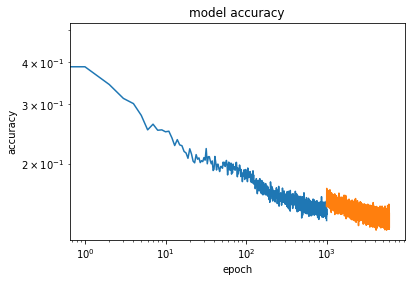

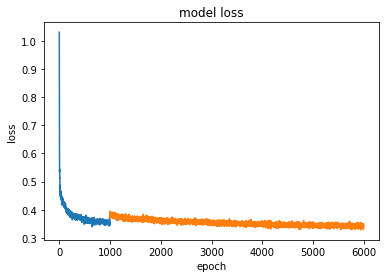

In [212]:
figure()
print(history3.history.keys())
#plot(history.history['acc'])
plot(history3.epoch,
1.0-array(history3.history['acc']))
plot(max(array(history3.epoch)*1.0)+array(history4.epoch),1.0-array(history4.history['acc']))

title('model accuracy')
ylabel('accuracy')
xlabel('epoch')
xscale("log")
yscale("log")

figure()
plot(history3.history['loss'])
plot(max(array(history3.epoch)*1.0)+array(history4.epoch),history4.history['loss'])

title('model loss')
ylabel('loss')
xlabel('epoch')

In [215]:
model.save("classifierFt20181204C.h5")


In [607]:
sum(pars==1)


258

In [608]:
len(pars[:])

1015

In [613]:
wfinal = model.weights[-1]